## **Sistemas Inteligentes - Práctica 2: Visión Artificial y Aprendizaje.**



---




# **Índice**

1.   Explicación, visualización y ejecución del código AdaBoost.
2.   Explicación breve sobre la adaptación de la base datos MNIST al algoritmo AdaBoost.
3.   AdaBoost y correlación con los porcentajes de aciertos y fallos.
4.   Clasificadores débiles, preguntas relacionadas y gráficas.

  4.1. ¿Cuál es el número de clasificadores que se han de generar para que un clasificador débil funcione?

  4.2. ¿Cómo afecta el número de clasificadores generados al tiempo empleado para el proceso de aprendizaje? ¿Qué importancia le darías?

  4.3. ¿Cómo has dividido los datos en conjunto de entrenamiento y test? ¿Para qué es útil hacer esta división?

  4.4. ¿Has observado si se produce sobre entrenamiento?

  4.5. ¿Cómo has conseguido que Adaboost clasifique entre los 10 dígitos cuando solo tiene una salida binaria? 

6.   Conclusión.


---


# **1. Explicación y visualización del código.**

Antes de nada debemos realizar algunas importaciones de librerías externas para el funcionamiendo correcto del programa.



In [1]:
# Importamos las librerias que necesitaremos
import numpy as np
import matplotlib.pyplot as plt
import math
import random

Ahora vamos a ver como he desarrollado el algoritmo AdaBoost.
En primer lugar creamos e inicializamos variables necesarias para el funcionamiento del algoritmo, como 'D' dónde guardamos las probabilidades de todas las imágenes (inicalizado con '1/60000' para todos sus valores), 'errores' dónde almacenamos los errores de los clasificadores débiles generados (inicialmente a infinto), 'alphas' dónde guardamos el grado de confianza de los clasificadores y 'h' dónde almacenamos los clasificadores débiles que formarán el clasificador fuerte.

Una vez definidas las variables, comenzamos con el funcionamiento real de AdaBoost. En primer lugar observamos un bucle que se ejecuta 'T' veces, valor que le pasamos por argumento y que define el número de clasificadores débiles que formarán el fuerte.

Dentro de ese bucle vemos otro bucle que se ejecuta 'A' veces, también se lo pasamos por parámetro, y que define el número de clasificadores aleatorios a generar, entre los cuales escogeremos el mejor de ellos. Este bucle crea el generador llamando a la función "generar_clasificador_debil()" y obtiene su error llamando a la función "obtener_error". Después comprobamos si el error es menor que los generados anteriormente, y si se cumple lo sustituimos.

Una vez obtenido el mejor clasificador débil aleatorio, lo guardamos y obtenemos su valor de confianza. Después se recalcula el array 'D', dando mayor importancia a las imágenes con menor error, y se normaliza todas sus componentes.

Esto se ejecuta tantas veces como nosotros creamos conveniente para obtener un buen resultado.

In [2]:
def entrenar(X, Y, T, A):
    # Y array con -1 y 1 dependiendo de si es de la clase
    # X imagenes que le pasamos
    
    # Número de imagenes: 60.000
    N = 45000
    # Lista con los grados de confianza de los clasificadores
    alphas = list()
    inicializar(alphas, T)
    # Lista con las probabilidades de las imagenes creado con numpy
    D = np.ones(N, dtype = np.double)/N
    # Lista con los errores de todos los clasificadores generados creado con numpy
    errores = np.ones(N, dtype = np.double) * np.inf
    # Lista con los clasificadores debiles creados
    h = list()
    
    # numero de clasificadores debiles a usar
    for t in range(T):
        # numero de pruebas aleatorias
        for k in range(A): 
            # Obtenemos un clasificador debil
            c_d = generar_clasificador_debil()
            # Calculamos el error 
            c_d.error = obtener_error(c_d, X, Y, D) # almacenamos el error de cada clasificador
            
            # Obtenemos el mejor clasificador débil
            if c_d.error<errores[t]:
                mejorClasificador = c_d
                errores[t] = c_d.error
  
        # Almacenamos el mejor clasificador débil
        h.append(mejorClasificador)
        # Obtenemos el alpha
        alphas[t] = 0.5 * math.log( ( (1 - errores[t]) / errores[t] ), 2)
        
        # Variable que acumula la suma de todos los elementos de D para después normalizar
        suma = 0
        # Actualizamos D para la siguiente iteración del bucle
        for i in range(N):
            D[i] = D[i] * math.exp(-alphas[t] * Y[i] * aplicar_clasificador_debil(h[t], X[i])) # No se si está bien
        
        # Normalizamos D
        D = D / np.sum(D)
            
    # Devolvemos los mejores clasificadores débiles y sus alphas, para posteriormente generar un clasificador fuerte
    return (h, alphas)

Esta función utiliza la siguiente función auxiliar para inicializar el vector 'alphas' que contendrá los grados de confianza de los clasificadores que formarán el clasificador fuerte:

In [3]:
# Vector que inicializa el vector de alphas a 0
def inicializar(x, n):
    for i in range(n):
        x.append(0)

Ahora vamos a ver las funciones "generar_clasificador_debil()", "obtener_error()" y "aplciar_clasificador_debil()", las cuales son necesarias para AdaBoost.

La primera función genera un clasificador aleatorio con un pixel random entre 0-783, un valor de escala de grises entre 0-255 y una dirección '0' para '<' y '1' para '>'.

La segunda función aplica el clasificador débil a una imagen. Para ello ve la dirección del clasificador y comprueba si el umbral del clasificador es menor o mayor (dependiendo de la dirección) que el pixel de la imagen. Si satisface la condición devuelve '1' si no devuelve '-1'.

La tercera función obtiene el error de un clasificador aplicandolo a todas las imágenes de la base de datos de MNIST. El método recorre todas las imagenes y comprueba si el valor devuelto por "aplicar_clasificador_debil" devuelve lo mismo que el array 'Y' para cada imagen. Si no coinciden se acumula el error 'D[i]', 

In [4]:
# Dimension con la que vamos a trabajar. En nuestro caso 28*28
def generar_clasificador_debil():    
    clasificador = Clasificador(random.randint(0, 783), random.randint(0, 255), random.randint(0, 1))
    return clasificador


def aplicar_clasificador_debil(clasificador, imagen):
    valorImagen = imagen[clasificador.pixel] # Almacenamos el valor dentro de la escala de grises correspondiente al pixel.
    
    # Si la dirección del clasificador es <
    if clasificador.direccion == 0:
        # Si el umbral del clasificador cumple con el umbral de la imagen        
        if clasificador.umbral < valorImagen:
            return 1
        
        else:
            return -1
    # Si la dirección del clasificador es >
    else:
        # Si el umbral del clasificador cumple con el umbral de la imagen
        if clasificador.umbral > valorImagen:
            return 1
        
        else:
            return -1
        

def obtener_error(clasificador, X, Y, D):
    # Aplicamos el clasificador a todas las imagenes
    result = 0
    # Lista con todos los resultados de aplicar el clasificador a todas las imagenes
    y_d = list()
    for i in range(45000):
        res = aplicar_clasificador_debil(clasificador, X[i])
        if Y[i] == 1 and res == 1:
            y_d.append(True)
            result += 0
            
        elif Y[i] == 1 and res == -1:
            y_d.append(False)
            result += D[i]
            
        elif Y[i] == -1 and res == 1:
            y_d.append(False)
            result += D[i]
        
        elif Y[i] == -1 and res == -1:
            y_d.append(True)
            result += 0

    return result

Cada clasificador débil generado se guarda como un objeto de la clase 'Clasificador', cuya declaración es la siguiente:

In [5]:
class Clasificador():
    def __init__(self, pixel, umbral, direccion):
        self.pixel = pixel
        self.umbral = umbral
        self.direccion = direccion

Una vez obtenidos el clasificador fuerte, he declarado las dos siguientes funciones.

La primera función obtiene el signo que devuelve el clasificador fuerte para una imagen.

La segunda función devuelve el valor concreto que le asigna el clasificador fuerte a una imagen.

In [6]:
def aplicarClasificadorFuerteSigno(classifier, imagen):
    (h, alphas) = classifier
    
    fuerte = []
    for i in range(len(alphas)):
        if i == 0:
            fuerte = np.double(alphas[i] * aplicar_clasificador_debil(h[i], imagen))
        
        else:
            fuerte = fuerte + np.double(alphas[i] * aplicar_clasificador_debil(h[i], imagen))
            
    return np.sign(fuerte)

def aplicarClasificadorFuerte(classifier, imagen):
    (h, alphas) = classifier
    
    resultado = []
    for i in range(len(alphas)):
        if i == 0:
            resultado = np.double(alphas[i] * aplicar_clasificador_debil(h[i], imagen))
        
        else:
            resultado = resultado + np.double(alphas[i] * aplicar_clasificador_debil(h[i], imagen))
            
    #print(resultado)
    return resultado

Antes de entrar a ver la ejecución del programa, vamos a ver tres funciones que necesitamos para ejecutar el código de forma correcta. Las dos primeras han sido proporcionadas por el profesorado, la tercera la he implementado yo.

Explicaré la adaptación de la base de datos de MNIST en el próximo apartado, para seguir con el orden del índice.

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_imagen(imagen):
    plt.figure()
    plt.imshow(imagen)
    plt.show()

def plot_arrays(X, Y, title):
    plt.title(title)
    plt.plot(X, Y)
    plt.show()

def adaptar_conjuntos(mnist_X, mnist_Y, n):
    Y_Entrenamiento = list()
    Y_Test = list()
    X_Entrenamiento = list()
    X_Test = list()
    
    for i in range(len(mnist_Y)):
        if i < 45000:
            if mnist_Y[i] == n:
                Y_Entrenamiento.append(1)
            else:
                Y_Entrenamiento.append(-1)

            arr = np.array(mnist_X[i])
            X_Entrenamiento.append(arr.flatten())

        else:
            if mnist_Y[i] == n:
                Y_Test.append(1)
            else:
                Y_Test.append(-1)

            arr = np.array(mnist_X[i])
            X_Test.append(arr.flatten())
            
        
    
    return (X_Entrenamiento, X_Test, Y_Entrenamiento, Y_Test)

Posteriormente cargamos la base de datos a partir del archivo proporcionado por el profesor. Después, almacenamos en dos arrays los elementos cargados, en la variable 'mnist_X' guardamos todas las imágenes, y en la variable 'mnist_Y' guardamos el valor real de las imágenes de la variable anterior.

In [9]:
# Cargamos la base de datos
npzfile = np.load("mnist.npz")
mnist_X = npzfile['x']
mnist_Y = npzfile['y']

Ahora vamos a declara el valor de 'T' y de 'A':

In [10]:
# Veces a iterar el bucle exterior del algoritmo (clasificadores débiles que formarán el fuerte)
T = 40
# Veces a iterar el bucle interior del algoritmo (clasificadores débiles aleatorios generados para elegir el mejor)
A = 60

Una vez definidas todas las funciones que vamos a utilizar vamos a poner la primera prueba al algoritmo. Esta va a consistir en, a partir de un valor, ver con que probabilidad el algoritmo acierta si es ese número.

In [11]:
################# Entrenamiento para el valor 0 #################

# Declaramos una variable con el número de elementos de Mnist
N = len(mnist_Y)

# Variable del número que queremos entrenar
VALOR = 0

# Se le pasa el valor para el cual queremos entrenar y adaptamos los conjuntos de MNIST
(X_Entrenamiento, X_Test, Y_Entrenamiento, Y_Test) = adaptar_conjuntos(mnist_X, mnist_Y, VALOR) 

(h, alphas) = entrenar(X_Entrenamiento, Y_Entrenamiento, T, A)

cont = 0
for i in range(15000): # Esto es para sacar el procentaje de aciertos, si quiero ver si un número lo clasifica bien lo cojo directamente del array y le paso el clasificador
    signo = aplicarClasificadorFuerteSigno((h, alphas), X_Test[i])
    if (signo == 1 and Y_Test[i] == 1) or (signo == -1 and Y_Test[i] == -1):
        cont += 1

# Obtenemos el porcentaje
acierto = (cont * 100) / 15000

print("Para el valor " + str(VALOR) + " el clasificador fuerte clasifica bien el " + str(acierto) + "% de los números con T = " + str(T) + " y A = " + str(A))

Para el valor 0 el clasificador fuerte clasifica bien el 95.28666666666666% de los números con T = 20 y A = 20


Después de comprobar que el clasificador fuerte tiene un porcentaje de acierto bastante considerable para valores bajos, y procentajes muy buenos para valores más elevados, vamos a ver como nuestro programa, entrenando 10 clasificadores, uno para cada valor 0-9 y ver su porcentaje de acierto.

In [ ]:
################# Entrenamiento para todos los valores #################

# Creamos todos los conjuntos para todos los valores posibles 0-9
conjuntos = list()
for i in range(10):
    (X_Entrenamiento, X_Test, Y_Entrenamiento, Y_Test) = adaptar_conjuntos(mnist_X, mnist_Y, VALOR)
    conjuntos.append((X_Entrenamiento, Y_Entrenamiento))

# Creamos un clasificador fuerte para cada valor posible 0-9
clasificadores_fuertes = list()
for i in range(10):
    clasificadores_fuertes.append(entrenar(conjuntos[i][0], conjuntos[i][1], T, A))

# Obtenemos que valor tiene el clasificador con mejor clasificación para la imagen
mejor_valor = -1
for i in range(15000):
    imagen = X_Test[i]
    for j in range(len(clasificadores_fuertes)): # 0 - 9
        y = aplicarClasificadorFuerte(clasificadores_fuertes[j], imagen)
        if y > mejor_valor:
            mejor_valor = y
            numero_resultado = i

    if numero_resultado == mnist_Y[45000 + i]:
        cont += 1

# Obtenemos el porcentaje
acierto = (cont * 100) / 15000
print("AdaBoost clasifica bien el " + str(acierto) + "% de las veces.")

AdaBoost clasifica bien el 91.70666666666666% de las veces.


Con el siguiente código vamos a ver una gráfica que representa el porcentaje de aciertos para distintos valores de A y T.

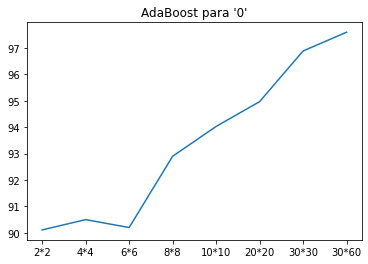

In [ ]:
# Almacenamos los valores obtenidos a ejecutar el algoritmo 
valores = ["2*2", "4*4", "6*6", "8*8", "10*10", "20*20", "30*30", "30*60"]
resultados = [90.11, 90.5, 90.2, 92.9, 94.03, 94.97, 96.89, 97.6]

# Imprimimos la gráfica
plot_arrays(valores, resultados, "AdaBoost para '0'")

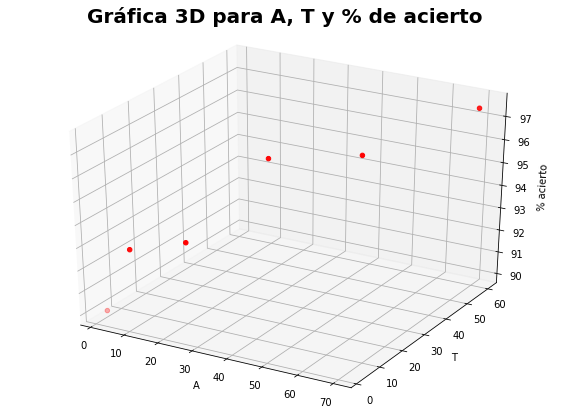

In [12]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

As = [2, 8, 20, 30, 50, 70]
Ts = [2, 4, 10, 30, 40, 60]
ACIERTOS = [90.11, 92.9, 93.2, 95.9, 96.03, 97.45]

fig=plt.figure(figsize=(8,6))
axes = plt.axes(projection="3d")
axes.scatter3D(As,Ts,ACIERTOS,color="red")
axes.set_title("Gráfica 3D para A, T y % de acierto\n",fontsize=20,fontweight="bold")
axes.set_xlabel("A")
axes.set_ylabel("T")
axes.set_zlabel("% acierto")
plt.tight_layout()
plt.show()

# **2. Explicación breve sobre la adaptación de la base datos MNIST al algoritmo AdaBoost.**

Para adaptar los arrays que obtendremos de la base de datos de MNIST, en primer lugar tendré que pasar cada imagen que compone el array a vector, en vez de dejarla como una imagen de 28*28, con el objetivo de que a la hora de aplicar el clasificador débil a una imagen, como el píxel que hemos generado va desde 0 hasta 783, si tenemos la imagen como una matriz tendríamos que obtener el pixel correspondiente de la matriz tantas veces como imágenes tengamos, lo cual relentizaría bastante el código. Para evitar eso convertimos cada imagen a un vector en la primera iteración del programa.

En segundo lugar, el array 'mnist_Y' contiene el valor entre 0 y 9 de la imagen en su misma posición en el array 'mnist_X'. En lugar de ello lo vamos a adaptar para que dado un valor, rellene un nuevo array 'Y' con, 1 si el valor pasado coincide con el de la imagen y '-1' si contiene uno distinto.


# **3. AdaBoost y correlación con los porcentajes de aciertos y fallos.**

AdaBoost entrena de forma secuencial un conjunto de aprendices (clasificadores) débiles a partir de un algoritmo base común. Todos los aprendices son entrenados con el mismo conjunto de datos pero éstos van recibiendo pesos que dependen de los errores cometidos por cada aprendiz. Cada aprendiz débil se genera aleatoriamente para cada ejecución, dependiendo del valor de 'A', se generan tantos aprendices. De todos los generados se elige el mejor, lo cual, cuanto más alto sea 'A' tenemos mayor probabilidad de nuestro aprendiz sea mejor. Por otro lado 'T' determina el número de estos aprendices débiles que formarán el aprendiz fuerte, por lo tanto cuanto más grande sea 'T', más grado de confianza vamos a tener en el aprendiz fuerte.

Sin embargo, aunque a mayores valores de 'A' y 'T' tendremos mejor rendimiento, los aprendices se generan de manera aleatoria, lo cual puede haber casos muy concretos en los que para valores pequeños se genera un aprendiz muy bueno, y que para valores muy grandes, es posible que el aprendiz no sea mejor o que sea incluso peor.

Por otro lado, estamos trabajando con imágenes de 28*28, y aleatoriamente elegimos un píxel al azar, lo cual puede significar que ese píxel no clasifique a la perfección para todas las imágenes.

Por lo tanto, he realizado numeros pruebas con distintos valores de 'A' y T', por lo general, la tasa de error con 'A' y 'T' igual a 2, la tasa de acierto suele estar en torno al 89% de acierto, aunque se pueden dar picos de 70% o 60% de acierto solamente. A medida que he ido subiendo estos valores la tasa de error ha ido disminuyendo hasta llegar a obtener un 97'5% de acierto en numerosas ocasiones, incluso picos de 98.2%. Para obtener estos resultados he usado valores de 40 tanto para 'A' como para 'T'. Considero que el intervalo de 40 a 50 para 'A' y para 'T' son unos valores muy buenos para AdaBoost en este programa, ya que los resultados son muy cercanos al 100%, y además el tiempo que tarda en ejecutarse no es tan elevado. Por supuesto si aumentaramos estos valores podríamos obtener una pequeña mejora, pero considero que el gasto de tiempo no compensa la mejora.

# **4. Clasificadores débiles, preguntas relacionadas y gráficas.**

**4.1. ¿Cuál es el número de clasificadores que se han de generar para que un clasificador débil funcione?**

Esta pregunta puede variar ya que los clasificadores se generan con valores al azar. Con valores dónde la salida es instantanea como 2 para 'A' y 'T' ya se puede llegar a obtener una tasa de acierto considerable, sin embargo pueden haber ejecuciones dónde la tasa de error aumente mucho, lo cuál no queremos. Por lo tanto, considero que para que nuestra tasa de acierto sea uniforme y alta en la mayoría de ejecuciones debemos tener unos valores para 'T' en torno a 30 o 40, y de 'A' sobre 60 o 70. Obviamente con valores más elevados vamos a obtener resultados mejores, pero como mínimo creo que esos valores no deben bajar de lo dicho anteriormente. Este argumento se basa en observar mi programa para distintos valores y probarlo varias ejecuciones para afirmar que lo que digo es correcto.

**4.2. ¿Cómo afecta el número de clasificadores generados al tiempo empleado para el proceso de aprendizaje? ¿Qué importancia le darías?**

Cada clasificador generado implica crear 'A' clasificadores débiles, los cuales se entrenan con 60.000 imágenes, lo cual supone un cálculo computacional considerable. Sin embargo, es necesario sacrificar un poco de tiempo si aseguramos tasas de error muy bajas, como es nuestro caso. 

Por cada iteración 't' se tienen que ejecutar lo dicho anteriormente, por lo que un valor muy elevado de 'T' puede dar lugar a que el programa tarde más tiempo del que considero correcto. 

Por lo tanto considero que se debe llegar a un punto medio, conseguir una tasa de acierto en torno al 97% y que el tiempo empleado no sea mayor a 12-15 minutos.

**4.3. ¿Cómo has dividido los datos en conjunto de entrenamiento y test? ¿Para qué es útil hacer esta división?**

Para separar he hecho que la función "adaptar_conjuntos" guarde las 45.000 primeras imágenes en un array "X_Entrenamiento" con el cuál realizaremos los entrenamientos para cada clasificador fuerte, y las siguientes 15.000 en un array "X_Test" con el que comprobaremos si los clasificadores fuertes clasifican bien las las imágenes. Lo mismo para el array 'Y'.

Esto es útil para comprobar que nuestro programa funciona de manera correcta con imágenes las cuales no ha sido entrenado.

Aquí dejo la función:



In [ ]:
def adaptar_conjuntos(mnist_X, mnist_Y, n):
    Y = list()
    X_Entrenamiento = list()
    X_Test = list()
    
    for i in range(len(mnist_Y)):
        if mnist_Y[i] == n:
            Y.append(1)
        else:
            Y.append(-1)

        if i < 45000:
            arr = np.array(mnist_X[i])
            X_Entrenamiento.append(arr.flatten())

        else:
            arr = np.array(mnist_X[i])
            X_Test.append(arr.flatten())
            
        
    
    return (X_Entrenamiento, X_Test, Y)

**4.4. ¿Has observado si se produce sobreentrenamiento?**

Efectivamente, si usamos valores muy altos sobretodo de 'A', llega un punto que los clasificadores débiles generados no son relevantes y la mejora en la tasa de acierto es insignificante, en el que caso de que haya mejora lo cual no es seguro. Al ser los clasificadores generados aleatoriamente esto puede variar mucho.

En cuanto a 'T', al almacenar junto a cada clasificador su grado de confianza, aunque generemos un número elevado de clasificadores fuertes vamos a darle más importancia a aquellos con mayor 'alpha'.

Tras realizar una gráfica 3D con el valor de 'A', 'T' y el % de acierto, he observado que llega un punto en el que el valor de 'A' hace que el % de acierto no aumente y sea uniforme.

In [ ]:
# Almacenamos los valores obtenidos a ejecutar el algoritmo 
valores = ["30*60", "40*60", "50*60", "60*60", "70*90"]
resultados = [97.6, 96.5, 97.7, 97.6, 97.4]

# Imprimimos la gráfica
plot_arrays(valores, resultados, "AdaBoost para distintos valores de A y T")

**4.5. ¿Cómo has conseguido que Adaboost clasifique entre los 10 dígitos cuando solo tiene una salida binaria?**

AdaBoost nos devuelve un clasificador fuerte, formado por 'T' clasificadores débiles. Para realizar la clasificación uso dos bucles, uno que recorre las imágenes de test y otro que recorre los clasificadores fuertes para cada valor posible 0-9. Por cada iteración de este bucle aplicamos el clasificador fuerte con la función declarada en el primer apartado "aplicarClasificadorFuerte()" y almacenamos el número asociado al clasificador que devuelva el valor más alto. Una vez hecho comprobamos si el número asociado corresponde con el almacenado en 'Y_Test' y si coinciden podemos afirmar que el clasificador fuerte determina que el número de forma correcta

Aquí dejo el trozo de código al que hago referencia en ese apartado, para comprobar la ejecución correcta se puede usar el cuadro de código del apartado 1 correspondiente.

In [ ]:
mejor_valor = -1
for i in range(15000):
    imagen = X_Test[i]
    for j in range(len(clasificadores_fuertes)): # 0 - 9
        y = aplicarClasificadorFuerte(clasificadores_fuertes[j], imagen)
        if y > mejor_valor:
            mejor_valor = y
            numero_resultado = i

    if numero_resultado == mnist_Y[45000 + i]:
        cont += 1

# **4. Conclusión.**

Una vez desarrollado el programa de forma correcta y haber realizado numerosas pruebas para distinos valores usados para calcular AdaBoost, creo que hemos realizado una práctica muy útil y con un gran potencial para el desarrollo de futuros programas relacionados con la visión artificial tanto en la universidad como en nuestra vida profesional.